##### 新潟大学大学院医歯学総合研究科　顎顔面放射線学分野　学生演習用
Modified by H.Nishiyama<br>
Fork from :https://github.com/oreilly-japan/deep-learning-from-scratch-5

```os.path.dirname(__file__)```<br>
はローカル実行環境ではエラーとなるので、<br>
```os.getcwd()```<br>
に修正した（オリジナルコードは```#=#```でコメントアウトしている）<br>
なお、ファイルの場所が同じフォルダ内なら、```os.path.join```も不要で、直接```np.loadtxt(path)```の```path```にファイル名（```'old_faithful.txt'```）を入れるだけで良い。<br>
【注意】オリジナルコードとして同梱されている「notebooks」フォルダ内のコードをローカルで直接実行すると同一フォルダ内に該当するデータファイルが存在しないのでエラーが発生する。<br>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#=# path = os.path.join(os.path.dirname(__file__), 'old_faithful.txt')
path = os.path.join(os.getcwd(), 'old_faithful.txt')
xs = np.loadtxt(path)
print(xs.shape) # (272, 2)

(272, 2)


In [3]:
# initialize parameters
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis)  # 2
N = len(xs)  # 272
MAX_ITERS = 100
THRESHOLD = 1e-4

In [4]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

In [5]:
def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

In [6]:
def likelihood(xs, phis, mus, covs):
    """ log likelihood """
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N

In [7]:
current_likelihood = likelihood(xs, phis, mus, covs)

for iter in range(MAX_ITERS):
    # E-step ====================
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs)

    # M-step ====================
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]  # column vector
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]

    # thershold check ====================
    print(f'{current_likelihood:.3f}')

    next_likelihood = likelihood(xs, phis, mus, covs)
    diff = np.abs(next_likelihood - current_likelihood)
    if diff < THRESHOLD:
        break
    current_likelihood = next_likelihood

-16.538
-4.415
-4.357
-4.302
-4.245
-4.200
-4.164
-4.156
-4.155


In [8]:
# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

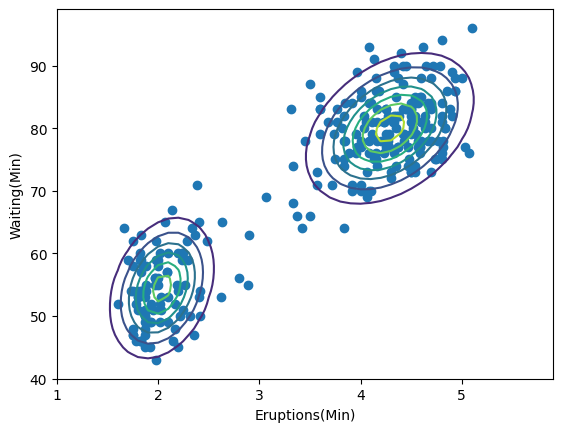

In [9]:
plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()